# Minimal example of forward simulation

This notebook is meant to orient users of the package to the best objects and patterns for forward simulation of a dynamic model. It was used to produce the histograms of infections in Figure 1. This is the best starting place to understand how to proceed with your own experiments and to learn important information about the crucial package `pandas` and how `DataFrame` objects can be manipulated to study the results of experiments.

# Google Colab initialization

This section will help you interface with Google Drive and clone the git repository where the code lives. These steps **aren't necessary if you are running locally**. First, make sure you have opened the notebook in Google Colab (use the below button if ncessary) and logged into your Google account.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/tanderson11/householdheterogeneity/blob/main/notebooks/MinimalForwardSimulation.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%mkdir /content/gdrive/My\ Drive/github/
%cd /content/gdrive/My\ Drive/github/
# Thayer has his files located here instead
#%cd /content/gdrive/My\ Drive/github/paper_push


In [ ]:
# If you've forked the repository, point to your own username and repository name (if different)
repo_owner="tanderson11"
repository="householdheterogeneity"

!git config --global user.email "tanderson11@gmail.com"
!git config --global user.name "Thayer Anderson"

In [ ]:
!git clone https://github.com/{repo_owner}/{repository}.git

In [ ]:
%cd householdheterogeneity/
!ls -a

# >>> TOKEN SETUP: <<<
# this will put your token in the right folder; comment this line out after use to avoid an error message
#!mv ../git_token.py ./
#!cp ../../householdheterogeneity/git_token.py ./

#from git_token import git_token

In [ ]:
!git checkout main
!git pull

In [ ]:
%cd ./notebooks

# Experiments

We start by importing `recipes` and `utilities`. `Recipes` contains the code that we use for running experiments easily, and utilities will help us define parameters and convert between different parameter sets.

In [1]:
# Initialization
%cd ../householdheterogeneity/
import src.recipes as recipes
import src.utilities as utilities
import src.model_inputs as model_inputs

[Errno 2] No such file or directory: '../householdheterogeneity/'
/Users/thayer/develop/covid_households/notebooks


To run experiments we define a `Model` object. The `Model` contains various settings and configurations, and it knows how to run experiments.

In [2]:
x = recipes.Model(state_lengths='lognormal')
x

Model(state_lengths='lognormal', forward_simulation='gillespie', initial_seeding='seed one by susceptibility', importation=None, secondary_infections=True, intervention=None)

To run an experiment, we use the `Model.run_trials()` method. We specify a population through a dictionary of sizes, and we specify a household beta (probability / unit time of transmission). 

In [3]:
# 1000 households of size 4 and 1000 households of size 5
df = x.run_trials(household_beta=0.05, sizes={5:1000, 4:1000})
df

count
size infections       
4    1             423
     2             102
     3             116
     4             359
5    1             325
     2              60
     3              35
     4              86
     5             494

To introduce heterogeneites, we add `traits` to the mix. Using `LognormalTrait` is recommended, but there are others like `GammaTrait`, `ConstantTrait` (with any constant value), and `BiModalTrait` (an n-fold difference between the two modes).

In [4]:
import src.traits as traits

# we use a helper method to create lognormal trait distributions with the desired mean and variance (on the /natural/, not the log scale)
susceptibility = traits.LognormalTrait.from_natural_mean_variance(mean=1.0, variance=0.5)
infectivity = traits.LognormalTrait.from_natural_mean_variance(mean=1.0, variance=2.0)

# specify the susceptibility distribution with the argument sus and likewise for inf 
df = x.run_trials(household_beta=0.05, sizes={8:2000}, sus=susceptibility, inf=infectivity)
df

count
size infections       
8    1             757
     2              92
     3              42
     4              18
     5              48
     6              65
     7             157
     8             821

## Experiments on grids

Sometimes, we want to run lots and lots of experiments over a region in parameter space. That might not be relevant yet, but here is how to do it!

Start by defining a region:

We're using $s_{80}$, $p_{80}$, and $\text{SAR}$ as the parameters in this example. If you want an explanation of them, let me know!

In [5]:
import numpy as np
s80_axis = np.linspace(0.2, 0.8, 3)
p80_axis = np.linspace(0.2, 0.8, 3)
sar_axis = np.linspace(0.10, 0.30, 3)
from typing import OrderedDict
axes_by_key = OrderedDict({'s80':s80_axis, 'p80':p80_axis, 'SAR':sar_axis})

# The second argument is a `ModelInputs` formula. It knows how to convert the parameters in axes_by_key into the default parameters. 
region = recipes.SimulationRegion(axes_by_key, model_inputs.S80_P80_SAR_Inputs)
region

SimulationRegion(axes_by_name=OrderedDict([('s80', array([0.2, 0.5, 0.8])), ('p80', array([0.2, 0.5, 0.8])), ('SAR', array([0.1, 0.2, 0.3]))]), parameter_class=<class 'src.model_inputs.S80_P80_SAR_Inputs'>)

In [14]:
DILUTION_PARAM = False
#DILUTION_PARAM = 0.75
target_SAR = 0.20
SAR_color_index = int(target_SAR*10-1)

Then we use `Model.run_grid()` to run at every point in the three-dimensional grid. We save the outputs (both incrementally and after we complete the simulations) in a folder that we specify.

In [15]:
import datetime
date_str = datetime.datetime.now().strftime("%m-%d-%H-%M")
!mkdir experiment_outputs/
dir_name = f"experiment_outputs/experiment-{date_str}"
!mkdir {dir_name}
results = x.run_grid({5:25000}, region, dir_name, divide_by_contacts=DILUTION_PARAM)
results.save(dir_name, 'results')

mkdir: experiment_outputs/: File exists


## Understanding what a `results` object and a `df` are

A results object has two associated attributes:

1. `results.metadata`: a record of the parameters and settings involved in simulating. It's helpful to carry this around to avoid accidentally combining results that don't represent the same model. But you probably don't need to worry about it too much!
2. `results.df`: a [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `DataFrame` object. This is essentially just a spreadsheet that records the observed numbers of infections for the different households at the different points in parameter space.

In [7]:
results.metadata

Metadata(constants={'delta_t': 0.1, 'infectious_period_duration_mean': 6.0, 'infectious_period_duration_std': 2.5, 'latent_period_duration_mean': 3.5, 'latent_period_duration_std': 2.5}, model=Model(state_lengths='lognormal', forward_simulation='gillespie', initial_seeding='seed one by susceptibility', importation=None, secondary_infections=True, intervention=None), population={5: 25000}, parameters=['s80', 'p80', 'SAR'])

## Plotting and Pandas tutorial

Here's a basic plotting example. Let's say we want to look at the histograms of infections stratified by how much heterogeneity is present (basically: a subpanel in the methods figure).

First we'll set up some nice colors (you don't have to worry about this).

In [17]:
import matplotlib.pyplot as plt
basic_sequential_cmap = plt.get_cmap("Greens")
alt_cmap = plt.get_cmap("Oranges")
colors = [basic_sequential_cmap(x) for x in np.linspace(0.2, 0.7, 3)]
colors[0] = [alt_cmap(x) for x in np.linspace(0.3, 0.6, 3)][SAR_color_index]

Now we group the dataframe by the values that we want to hold constant so that we can plot the infections over the variable of interest.

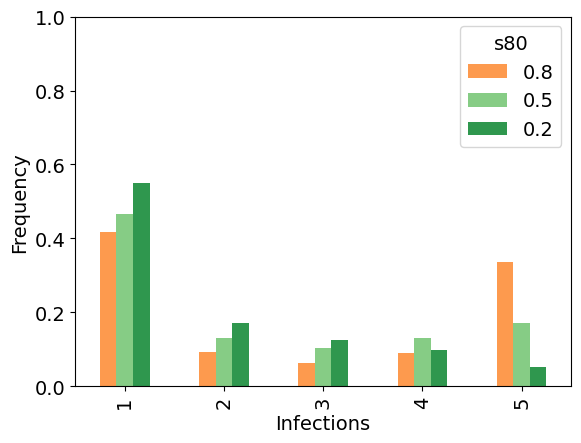

In [18]:
plt.rcParams.update({'font.size': 14,})
# we group by the variables we aren't interested in plotting so that they'll be constant in the slice we look at
grouping = ['p80', 'SAR', 'size']
for key, group in results.df.groupby(grouping): # we perform the grouping and iterate over groups
    group = group.rename(columns={0:'count'}) # I rename a mysterious column to make it more obvious. In future, this will be the default behavior!
    # we make key_dict, a mapping from labels (ex. 'p80') to the value in the current group
    key_dict = {label:key[i] for i,label in enumerate(grouping)}
    # we skip values we're not interested in
    if key_dict['p80'] != 0.8: continue
    if key_dict['SAR'] != target_SAR: continue

    # do some magic! (I'll explain down below)
    restructured_group = group['count'].reset_index().drop(['p80', 'SAR', 'size'], axis=1).set_index(['infections', 's80']).unstack()
    restructured_group = restructured_group.droplevel(0, axis=1)
    restructured_group = restructured_group / restructured_group.sum()
    # switch the order of our columns because *decreasing* s80 corresponds with *adding* heterogeneity
    switched_column_order = restructured_group[restructured_group.columns[::-1]]
    ax = switched_column_order.plot.bar(color=colors)
    break
#ax.axes.yaxis.set_ticklabels([])
ax.set_xlabel("Infections")
ax.set_ylabel("Frequency")
ax.set_ylim((0.0, 1.0))
plt.savefig("different_s80s.pdf", dpi=400)

In [10]:
restructured_group

s80,0.2,0.5,0.8
infections,,,
1,0.36768,0.30256,0.26576
2,0.14620,0.08332,0.04440
3,0.15160,0.08072,0.02860
4,0.18048,0.15588,0.05996
5,0.15404,0.37752,0.60128


You might be wondering what magic took place with all the setting and resetting of the index. I'll explain it below as a mini tutorial in `pandas`. But fortunately, a lot of this wizardry can be done automatically in the `utilities` and `fancy_plotting` parts of the module. I'll explain those more in the future.

Our starting point was the `group` object, a slice of the data where $p_{80}$, $\text{SAR}$, and the size were held constant.

In [11]:
group

count  sus_variance  inf_variance   beta  \
s80 p80 SAR size infections                                             
0.2 0.8 0.3 5    1            9192        16.002           NaN  0.146   
                 2            3655        16.002           NaN  0.146   
                 3            3790        16.002           NaN  0.146   
                 4            4512        16.002           NaN  0.146   
                 5            3851        16.002           NaN  0.146   
0.5 0.8 0.3 5    1            7564         1.031           NaN  0.073   
                 2            2083         1.031           NaN  0.073   
                 3            2018         1.031           NaN  0.073   
                 4            3897         1.031           NaN  0.073   
                 5            9438         1.031           NaN  0.073   
0.8 0.8 0.3 5    1            6644           NaN           NaN  0.061   
                 2            1110           NaN           NaN  0.061   
                 3             715           NaN           NaN  0.061   
                 4            1499           NaN           NaN  0.061   
                 5           15032           NaN           NaN  0.061   

                             inf_constant_value  sus_constant_value  
s80 p80 SAR size infections                                          
0.2 0.8 0.3 5    1                          1.0                 NaN  
                 2                          1.0                 NaN  
                 3                          1.0                 NaN  
                 4                          1.0                 NaN  
                 5                          1.0                 NaN  
0.5 0.8 0.3 5    1                          1.0                 NaN  
                 2                          1.0                 NaN  
                 3                          1.0                 NaN  
                 4                          1.0                 NaN  
                 5                          1.0                 NaN  
0.8 0.8 0.3 5    1                          1.0                 1.0  
                 2                          1.0                 1.0  
                 3                          1.0                 1.0  
                 4                          1.0                 1.0  
                 5                          1.0                 1.0

You can observe that there are three different values for $s_{80}$ in the index of this table (an index is just a special kind of column[s] in a table that is understood to label different entries sequentially).

Our desired endpoint needs to discard the miscellaneous data held in the table (used to verify its integrity) and get the different values of $s_{80}$ to be the **columns instead of the index**. That way, pandas will plot each of the columns separately in our bar plot. Here's our desired endpoint:

In [12]:
restructured_group

s80,0.2,0.5,0.8
infections,,,
1,0.36768,0.30256,0.26576
2,0.14620,0.08332,0.04440
3,0.15160,0.08072,0.02860
4,0.18048,0.15588,0.05996
5,0.15404,0.37752,0.60128


We get there first by selecting the revelvant column, "count," which counts the number of times we observe a certain number of infections. You can see our data is now only one column: (our index remains many columns)

In [13]:
step_by_step = group['count']
step_by_step

s80  p80  SAR  size  infections
0.2  0.8  0.3  5     1              9192
                     2              3655
                     3              3790
                     4              4512
                     5              3851
0.5  0.8  0.3  5     1              7564
                     2              2083
                     3              2018
                     4              3897
                     5              9438
0.8  0.8  0.3  5     1              6644
                     2              1110
                     3               715
                     4              1499
                     5             15032
Name: count, dtype: int64

Next we reset the index so that we can drop the parts of the index we don't care about (we drop them by naming the columns and specifying `axis=1` AKA: drop columns not rows). Afterwards, we set a new index to restore the two index columns that we wanted to keep:

In [14]:
step_by_step = step_by_step.reset_index().drop(['p80', 'SAR', 'size'], axis=1).set_index(['infections', 's80'])
step_by_step

,,count
infections,s80,
1,0.2,9192
2,0.2,3655
3,0.2,3790
4,0.2,4512
5,0.2,3851
1,0.5,7564
2,0.5,2083
3,0.5,2018
4,0.5,3897


Lastly, we use the magic of `unstack` to pivot our data. Essentially, we are taking the inner part of our index ($s_{80}$) and turning it into a group of columns by finding each row with the same value of $s_{80}$. This is a super useful operation that we use a lot.

In [15]:
step_by_step = step_by_step.unstack()
step_by_step

count             
s80          0.2   0.5    0.8
infections                   
1           9192  7564   6644
2           3655  2083   1110
3           3790  2018    715
4           4512  3897   1499
5           3851  9438  15032

And now we drop the "count" label that's hovering over our columns so that pandas can make sense of our data.

In [16]:
step_by_step = step_by_step.droplevel(0, axis=1) # axis=1 because we are dropping a level from the **column** names
step_by_step

s80,0.2,0.5,0.8
infections,,,
1,9192,7564,6644
2,3655,2083,1110
3,3790,2018,715
4,4512,3897,1499
5,3851,9438,15032


For infectivities (another subpanel):

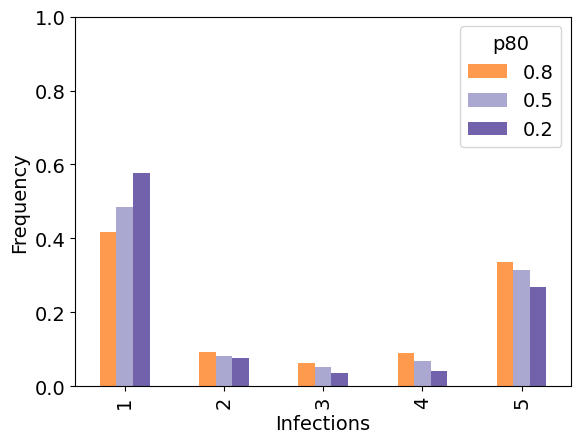

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14,})
basic_sequential_cmap = plt.get_cmap("Purples")
alt_cmap = plt.get_cmap("Oranges")
colors = [basic_sequential_cmap(x) for x in np.linspace(0.2, 0.7, 3)]
colors[0] = [alt_cmap(x) for x in np.linspace(0.3, 0.6, 3)][SAR_color_index]

# we group by the variables we aren't interested in plotting so that they'll be constant in the slice we look at
grouping = ['s80', 'SAR', 'size']
for key, group in results.df.groupby(grouping): # we perform the grouping and iterate over groups
    group = group.rename(columns={0:'count'}) # I rename a mysterious column to make it more obvious. In future, this will be the default behavior!
    # we make key_dict, a mapping from labels (ex. 'p80') to the value in the current group
    key_dict = {label:key[i] for i,label in enumerate(grouping)}
    # we skip values we're not interested in
    if key_dict['s80'] != 0.8: continue
    if key_dict['SAR'] != target_SAR: continue

    # do some magic! (I'll explain down below)
    restructured_group = group['count'].reset_index().drop(['s80', 'SAR', 'size'], axis=1).set_index(['infections', 'p80']).unstack()
    restructured_group = restructured_group.droplevel(0, axis=1)
    restructured_group = restructured_group / restructured_group.sum()
    # switch the order of our columns because *decreasing* s80 corresponds with *adding* heterogeneity
    switched_column_order = restructured_group[restructured_group.columns[::-1]]
    ax = switched_column_order.plot.bar(color=colors)
    break
#ax.axes.yaxis.set_ticklabels([])
ax.set_xlabel("Infections")
ax.set_ylabel("Frequency")
ax.set_ylim((0.0, 1.0))
plt.savefig("different_p80s.pdf", dpi=400)

In [18]:
restructured_group

p80,0.2,0.5,0.8
infections,,,
1,0.44496,0.34492,0.26576
2,0.05444,0.05280,0.04440
3,0.02596,0.02816,0.02860
4,0.03268,0.04560,0.05996
5,0.44196,0.52852,0.60128


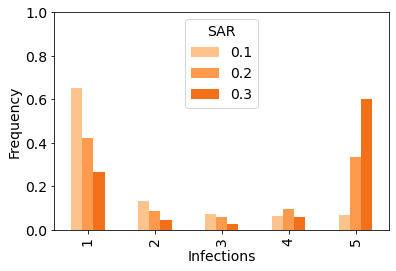

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14,})
basic_sequential_cmap = plt.get_cmap("Oranges")
alt_cmap = plt.get_cmap("Oranges")
colors = [basic_sequential_cmap(x) for x in np.linspace(0.3, 0.6, 3)]

# we group by the variables we aren't interested in plotting so that they'll be constant in the slice we look at
grouping = ['s80', 'p80', 'size']
for key, group in results.df.groupby(grouping): # we perform the grouping and iterate over groups
    group = group.rename(columns={0:'count'}) # I rename a mysterious column to make it more obvious. In future, this will be the default behavior!
    # we make key_dict, a mapping from labels (ex. 'p80') to the value in the current group
    key_dict = {label:key[i] for i,label in enumerate(grouping)}
    # we skip values we're not interested in
    if key_dict['s80'] != 0.8: continue
    if key_dict['p80'] != 0.8: continue

    # do some magic! (I'll explain down below)
    restructured_group = group['count'].reset_index().drop(['s80', 'p80', 'size'], axis=1).set_index(['infections', 'SAR']).unstack()
    restructured_group = restructured_group.droplevel(0, axis=1)
    restructured_group = restructured_group / restructured_group.sum()
    # switch the order of our columns because *decreasing* s80 corresponds with *adding* heterogeneity
    #switched_column_order = restructured_group[restructured_group.columns[::-1]]
    ax = restructured_group.plot.bar(color=colors)
    break
#ax.axes.yaxis.set_ticklabels([])
ax.set_xlabel("Infections")
ax.set_ylabel("Frequency")
ax.set_ylim((0.0, 1.0))
plt.savefig("different_SARs.pdf", dpi=400)

In [20]:
restructured_group

SAR,0.1,0.2,0.3
infections,,,
1,0.65496,0.42056,0.26576
2,0.13296,0.08904,0.04440
3,0.07536,0.06152,0.02860
4,0.06616,0.09520,0.05996
5,0.07056,0.33368,0.60128
